<a href="https://colab.research.google.com/github/Wezz-git/AI-samples/blob/main/Multivariate_Crypto_Forecasting_with_a_Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal:

To build an advanced, realistic forecasting model to see if we could predict the price of bitcoin for the next 7 days.

3 aims:

1 - It was Multivariate: I didn't just use Bitcoin's past price to predict its future. I fed the model other data (ETH, S&P 500, Gold, etc.), assuming these "covariates" contain information that helps predict Bitcoin's movements.

2 - It was Multi-Step: We didn't just predict tomorrow's price (a single step). We built a model that could forecast an entire sequence of 7 days into the future.

3 - Used a Transformer (TFT): Instead of a simpler model like an LSTM, we used a state-of-the-art Transformer, which is specifically designed to handle complex relationships between many different time series.

In [1]:
!pip install darts
!pip install yfinance

#Installed the libraries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

#Imported the tools needed

In [3]:
!pip install darts

In [4]:
import darts.models

In [5]:
#The main TimeSeries object
from darts import TimeSeries

#The transformer model we'll use
from darts.models import TFTModel

#A tool for scaling the data (Important)
from darts.dataprocessing.transformers import Scaler

#Metrics for evaluation
from darts.metrics import mape, rmse

##Getting the necessary tools needed from darts library

In [6]:
# Define our tickets.
# Target = BTC-USD
# Countraries = ETH-USD, SPY, GC=F, DX-Y

tickers_list = ['BTC-USD', 'ETH-USD', 'SPY', 'GC=F', 'DX-Y']
Start_date = "2019-01-01"

# Download data from yfinance
#print("Downloading data from yfinance...")
#data = yf.download(Ticketers, start=Start_date, interval='1d')

# We only want the 'Close' price data
#df = data['Close'].copy()

# Handle missing data. We forward-fill the last known price
#df = df.fillna(method='ffill')

# Drop any remaining rows at the beginning that are still NaN
#df = df.dropna()

# Remove tickers that failed to download
#downloaded_tickers = df.columns.tolist()
#Ticketers = [ticker for ticker in Ticketers if ticker in downloaded_tickers]

#print(df.tail()

# 2 - Create an empty list to store each DataFrame
all_data = []

print("Downloading data one by one")

# 3 - loop through each ticker, download it and add it to our list
for ticker in tickers_list:
  try:
    data = yf.download(ticker, start=Start_date, interval="1d")

    if data.empty:
      print(f"No data found for {ticker}. Skipping...")
      continue # Skip the ticker and move to the next one

    # Get just the 'Close' price
    df_ticker = data['Close'].copy()

    # Rename the 'Close" column to the ticker's name (eg 'BTC-USD')
    df_ticker.rename(columns={'Close' : ticker}, inplace=True)

    all_data.append(df_ticker)
    print(f"Successfully downladed: {ticker}")

  except Exception as e:
      print(f"-- ERROR downloading {ticker}: {e} --")

# 4 - Combine all DataFrames in the list into one
# axis=1 joins them side-by-side (as columns)
# join='outer' keeps all dates, even if one asset didnt trade
df = pd.concat(all_data, axis=1, join='outer')

# 5 - Handle missing data. We forward-fill the last known price. (eg Fridays SPY price over the weekend)
df = df.fillna(method='ffill')

# 6 - Drop any remaining rows at the very beginning that are still NaN
df = df.dropna()

print("\nAll data downloaded, joined and cleaned:")
print(df.tail())# show the last 5 rows to check
print(f"\nIs the final DataFrame empty? {df.empty}")

/tmp/ipython-input-2375759296.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=Start_date, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2375759296.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=Start_date, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2375759296.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=Start_date, interval="1d")


Successfully downladed: BTC-USD
Successfully downladed: ETH-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2375759296.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=Start_date, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2375759296.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=Start_date, interval="1d")


Successfully downladed: SPY
Successfully downladed: GC=F


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: DX-Y"}}}
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DX-Y']: YFTzMissingError('possibly delisted; no timezone found')


No data found for DX-Y. Skipping...

All data downloaded, joined and cleaned:
Ticker            BTC-USD      ETH-USD         SPY         GC=F
Date                                                           
2025-11-02  110639.625000  3911.063232  682.059998  3982.199951
2025-11-03  106547.523438  3602.308105  683.340027  4000.300049
2025-11-04  101590.523438  3292.574463  675.239990  3947.699951
2025-11-06  101590.523438  3292.574463  670.309998  3947.699951
2025-11-07  100400.281250  3243.465088  670.309998  4004.000000

Is the final DataFrame empty? False


/tmp/ipython-input-2375759296.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [7]:
print(df.tail())

Ticker            BTC-USD      ETH-USD         SPY         GC=F
Date                                                           
2025-11-02  110639.625000  3911.063232  682.059998  3982.199951
2025-11-03  106547.523438  3602.308105  683.340027  4000.300049
2025-11-04  101590.523438  3292.574463  675.239990  3947.699951
2025-11-06  101590.523438  3292.574463  670.309998  3947.699951
2025-11-07  100400.281250  3243.465088  670.309998  4004.000000


In [8]:
## Preoare data for the model
#(Darts needs its own special TimeSeries object. Need to deine our target and covariates)

# 1- convert entire DataFrame into single Darts TimeSeries onject
# This object is smart and understands the time index
#series = TimeSeries.from_dataframe(df, freq='D')

# 2-Scale the data (Necessary)
# Models like transformers need all data to be on a similar scale (eg 0 to 1)
#print("scaling data..")
#scaler = Scaler()
#series_scaled = scaler.fit_transform(series)

# 2. Split into target and covariates *before* scaling
#target_series = series['BTC-USD']
#covariate_series = series.drop('BTC-USD')

# 3. Create TWO separate scalers
#target_scaler = Scaler()
#cov_scaler = Scaler()

#3- Define our target (BTC) and our covariances (everything else)
# We use the scaled data
#target = series_scaled['BTC-USD']    ### target used in target.split.before

# Select all columns except 'BTC-USD' for covariates
#cov = series_scaled[['ETH-USD', 'SPY', 'GC=F']]    ### cov used in cov.split.before


# 4- Split into training and validation sets
# Using th e last 180 days for validating (testing)
# NO SHUFFLING - This is time series!
#val_split_point = len(target) - 180
#train_target, val_target = target_scale.split_before(val_split_point)
#train_cov, val_cov = cov.split_before(val_split_point)

#print(f"Training set length: {len(train_target)}")
#print(f"Validation set length: {len(val_target)}")

In [9]:
# 1. Convert the entire DataFrame into a single Darts TimeSeries object
series = TimeSeries.from_dataframe(df, freq='D')

# --- THIS IS THE NEW, FIXED LOGIC ---

# 2. Split into target and covariates *before* scaling
target_series = series['BTC-USD']
covariate_series = series[['ETH-USD', 'SPY', 'GC=F']]

# 3. Create TWO separate scalers
target_scaler = Scaler()
cov_scaler = Scaler()

# 4. Fit and transform them separately
print("Scaling target and covariates...")
target_scaled = target_scaler.fit_transform(target_series)
cov_scaled = cov_scaler.fit_transform(covariate_series)

# 5. Split into training and validation sets
val_split_point = len(target_scaled) - 150

train_target, val_target = target_scaled.split_before(val_split_point)
train_cov, val_cov = cov_scaled.split_before(val_split_point)

print(f"Training set length: {len(train_target)}")
print(f"Validation set length: {len(val_target)}")
print("Data preparation is complete and correct.")

Scaling target and covariates...
Training set length: 2352
Validation set length: 150
Data preparation is complete and correct.


In [10]:
## Build and train the transfer model
# this the AI part. Define the recipe for the model
# input_chuck_length = 90 (means look at last 90 days of data)
# output_chunk_length = 7 (predict next 7 days)

input_chuck_length = 90      # look at 90 days
output_chunk_length = 7      # predict next 7 days

# In colab, change runtime to T4 GPU.
# Makes training faster.
# With a GPU, Darts will use it automatically

pl_trainer_kwargs = {
    "accelerator": "auto",
    "devices": "auto",
    #"auto_select_gpus": True # Removed deprecated argument
}

# 1 - Create the TFTModel
model_tft = TFTModel(
    input_chunk_length=input_chuck_length,
    output_chunk_length=output_chunk_length,
    n_epochs=50,
    random_state=42,
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name="BTC_transformer"
)

# 2 - Train the model
# We give it the target and the covariates (the helper data)
print("training the Transformer model... (this will take a few)")
model_tft.fit(
    series=train_target,
    future_covariates=train_cov,  #In TFT, all covariates are 'future' covariates
    val_series=val_target,
    val_future_covariates=val_cov,
    verbose=True
)
print("Training done!")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training the Transformer model... (this will take a few)


INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.8 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K  | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K  | train
8  | static_context_cell_encoder_grn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Training done!


In [11]:
# Make & Evaluate predictions
# The model will predict the entire validation period and see how it did
# Darts hasa cool function called historical_forecasts. It runs a "backtest"

print("Running a historical forecast on the validation set...")

# This simulates making 7-day-ahead predictions every day
# On our validation data (the last 180 days)
backtest_forecasts = model_tft.historical_forecasts(
    series=target_scaled,                 # Give the full target series
    future_covariates=cov_scaled,         # and the full cov
    start=val_split_point,         # Start backtest at the split point
    forecast_horizon=7,             # make 7-day-ahead forecasts
    stride=1,                      # Make forecasts every day ( 1 day at a time)
    retrain=False,                 # dont retrain the model every day
    verbose=True
)

# 2 - Un-scale the data (to see real prices)
# we use the 'Scaler' we saved from step 4
forecast_unscale = target_scaler.inverse_transform(backtest_forecasts)
target_unscaled = target_scaler.inverse_transform(target_scaled)

# 3 - Calculate the error (MAPE = Mean Absolute Percentage Error)
mape_error = mape(target_unscaled[val_split_point:], forecast_unscale)
print(f"The MAPE error is: {mape_error: .2f}%")
print("This means, on average, our 7-day forecast was off by about {mape_error:.2f}%")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running a historical forecast on the validation set...


Predicting: |          | 0/? [00:00<?, ?it/s]

The MAPE error is:  8.66%
This means, on average, our 7-day forecast was off by about {mape_error:.2f}%


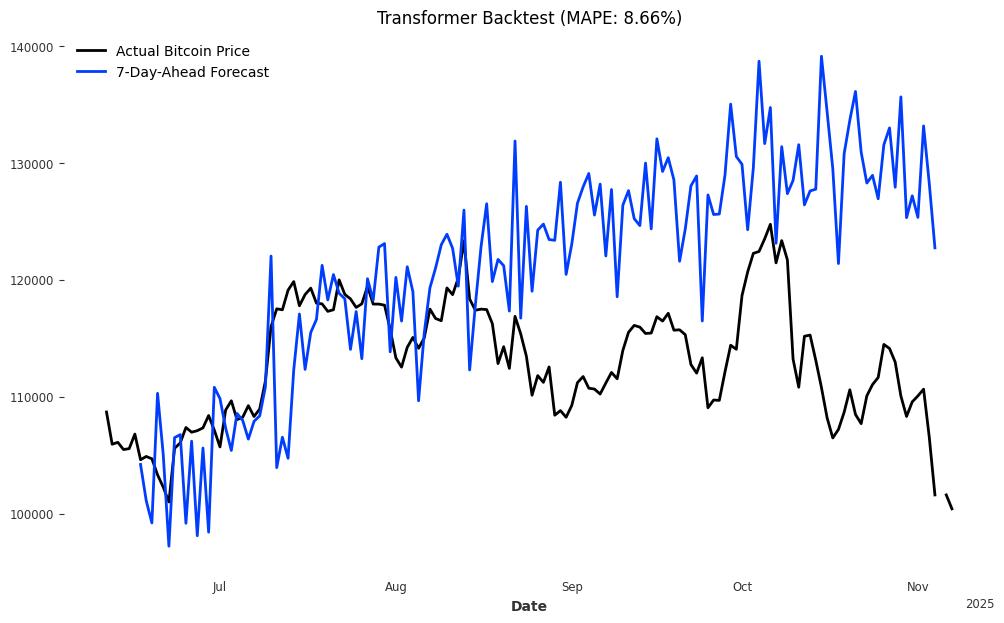

In [12]:
# Plot the results
plt.figure(figsize=(12, 7))
target_unscaled[val_split_point:].plot(label='Actual Bitcoin Price')
forecast_unscale.plot(label='7-Day-Ahead Forecast')
plt.title(f'Transformer Backtest (MAPE: {mape_error:.2f}%)')
plt.legend()
plt.grid()
plt.show()